$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\Tr}[0]{^\top}
\newcommand{\softmax}[1]{\mathrm{softmax}\left({#1}\right)}
$$

# CS236781: Deep Learning
# Tutorial 11: Generative Adverserial Networks


## Introduction

In this tutorial, we will cover:

- GAN
    - Adversery training
    - GAN Loss and Nash Equilibrium
    - GAN code example
    - GAN cons
- DCGAN
- W-GAN
- Conditional GAN
- StyleGAN


In [1]:
# Setup
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set()



# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Dataset 


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
# sklearn imports
from sklearn import mixture
from sklearn.manifold import TSNE

In [2]:
plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Recall: Discriminative Vs. Generative

<center><img src="img/gen_disc.jpg" width=1300 /></center>

## Variational-Autoencoder (VAE)

<center><img src="img/vae.png" width=1400 /></center>


## GAN (Generative Adverserial Networks)

Was first presented in <a href="http://papers.nips.cc/paper/5423-generative-adversarial-nets">Generative Adversarial Networks</a>, NIPS 2014, by Ian Goodfellow.

Gan is an implicit model, means it does not try to estimate $P(X)$ explicitly like VAE (not even $P(X|z$).

GAN has two components, `Generator` and `Discriminator` (you can think of them as encoder and decoder, but with diffrent routing) and the goal is to reach **zero-sum** cooperative game between them (minimax), as one component is adversery to the other.


`Generator` - generate fake samples.<br>
`Discriminator` - Try to detect fake samples and real samples.<br>

while both components could work by themself, they train in an adversery setup, means that they harm each other convergence.

before we dive into details, think that you pre-train a good Discriminator. now we want to train a Generator, but every attempt to generate good data is detected and it can't learn...

the same idea, let's say we somehow created an Okay Generator, if the discriminator can't distingish between fake and real, it can't give a feedback to improve the generator anymore.

<center><img src="img/2cf8b4f1-7163-4af1-aa4b-6066329d554a.png" width="750"/></center>

from game theory, the GAN model **converges** when the `discriminator` and the `generator` reach a **Nash equilibrium**.

<center><img src="img/russel.jpg" width="750"/></center>
image of Russell Crowe from "A Beautiful Mind" 
<br>
<br>
<br>



**Nash equilibrium** - happens when all of the *players* will not change their *action* regardless of what the opponents may do.
in the word of neural nets- each component is a *player* and updating the prediction (by changing weights) is the *action* 


At each time step we train both (in turns), and the goal is to reach equlibirum of both parts

let's look at an example:
<center><img src="img/1_hmbyMq-akpx-VRq7ZfnGFA.png" width="750"/></center>




### GAN Loss


Denote Discriminator as $D$,  Generator by $G$ and reward function by $V$,

The GAN's objective (Loss) function: $$ \min_G \max_D V(D,G)$$

It is formulated as a **minimax game**:
- $D$ is trying to *maximize* its reward $V(D, G)$
- $G$ is trying to *minimize* the Discriminator's reward (or maximize its loss)


**minimizing the Discriminator's reward** means that the Discriminator can not tell the difference between real and fake samples, thus, the Generator is "winning".


**Note** that we can't use one loss function (or can we?), as we did with the VAE, since each part here try to optimize the opposite, so we need two steps:

when we train the `Discriminator`, we freeze the generator and backpropogate the discriminator
<center><img src="img/gan_diagram_discriminator.svg" width="750"/></center>


when we train the `Generator`, we freeze the discriminator and backpropogate the Generator

<center><img src="img/gan_diagram_generator.svg" width="750"/></center>


$$ V(D,G) = \mathbb{E}_{x \sim p(x)} \left[ \log D(x) \right] + \mathbb{E}_{z\sim q(z)} \left[\log(1 - D\left(G(z)\right)) \right] $$
    
where D output's binary classification `0` for fake and `1` for real, and we use Binary Cross Entropy loss


<center><img src="img/1_losses.png" width="900"/></center>

For a given generator, the optimal discriminator is $D^*(x) = \frac{P_{data}(x)}{P_{data}(x) + P_{G}(x)} $

the proof comes from information theory, we actually using [Jensen–Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence) (a bit of a reminder of  **KL-divergence** )

$$ JSD( p_G\mid \mid p_{data}) = JSD(p_{data} \mid \mid p_G) = \frac{1}{2}KL\left(p_{data} \mid \mid \left(\frac{p_{data} + p_G}{2}\right)\right) +  \frac{1}{2}KL\left(p_G \mid \mid \left(\frac{p_{data} + p_G}{2}\right)\right)$$


* The **Nash equilibrium** is reached when:
    * $P_{data}(x) = P_{gen}(x), \forall x$
    * $D(x) = \frac{1}{2}$ (completely random classifier).
    
you can read the [Mathematical proof of Nash Equilibrium in GANs](https://srome.github.io/An-Annotated-Proof-of-Generative-Adversarial-Networks-with-Implementation-Notes/)


we're **not** going to go deeper into information theory or the proofs since that's out of the scope of the course.

for some intuition, you can try to see the process in [GANLab](https://poloclub.github.io/ganlab/)

Let's code the GAN model

In [3]:
# Hyperparameters
RANDOM_SEED = 42
GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002

NUM_EPOCHS = 50
BATCH_SIZE = 128

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 28, 28, 1

Since GANs are hard to train, we will try to stabelize the randomness as much as we can

In [4]:
import random
def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False #disable auto-tunner, work a bit slower but more stable
        torch.backends.cudnn.deterministic = True
    torch.set_deterministic(True)


def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_deterministic
set_all_seeds(RANDOM_SEED)

In [5]:
custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root='./data', 
                               train=True, 
                               transform=custom_transforms,
                               download=True)
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          shuffle=True)
# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


And like always, let's look at the data

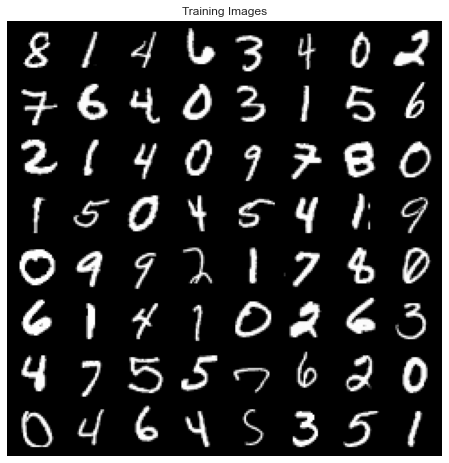

In [6]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64], 
            padding=2, normalize=True),(1, 2, 0)))
plt.show()

While usually we write the model as components, we will save some time (since the architecture is so naive):

In [7]:
##########################
### MODEL
##########################

class GAN(torch.nn.Module):

    def __init__(self, latent_dim=100, 
                 image_height=28, image_width=28, color_channels=1):
        super().__init__()
        
        self.image_height = image_height
        self.image_width = image_width
        self.color_channels = color_channels
        
        self.generator = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, image_height*image_width*color_channels),
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            nn.Flatten(),
            nn.Linear(image_height*image_width*color_channels, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1), # outputs logits
            #nn.Sigmoid()
        )
    
    def generator_forward(self, z):# z has dimension NCHW
        z = torch.flatten(z, start_dim=1) 
        img = self.generator(z)
        img = img.view(z.size(0),
                       self.color_channels,
                       self.image_height,
                       self.image_width)
        return img
    
    def discriminator_forward(self, img):
        logits = model.discriminator(img)
        return logits

In [8]:
set_all_seeds(RANDOM_SEED)

model = GAN()
model.to(device)


optim_gen = torch.optim.Adam(model.generator.parameters(),
                             betas=(0.5, 0.999),
                             lr=GENERATOR_LEARNING_RATE)

optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)

In [20]:
def train_gan_v1(num_epochs, model, optimizer_gen, optimizer_discr, 
                 latent_dim, device, train_loader, loss_fn=None,
                 logging_interval=100, 
                 save_model=None):
    
    log_dict = {'train_generator_loss_per_batch': [],
                'train_discriminator_loss_per_batch': [],
                'train_discriminator_real_acc_per_batch': [],
                'train_discriminator_fake_acc_per_batch': [],
                'images_from_noise_per_epoch': []}

    if loss_fn is None:
        loss_fn = torch.nn.functional.binary_cross_entropy_with_logits

    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device) # format NCHW

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            batch_size = features.size(0)

            # real images
            real_images = features.to(device)
            real_labels = torch.ones(batch_size, device=device) # real label = 1

            # generated (fake) images
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)  # format NCHW
            fake_images = model.generator_forward(noise)
            fake_labels = torch.zeros(batch_size, device=device) # fake label = 0
            flipped_fake_labels = real_labels # here, fake label = 1

            # --------------------------
            # Train Discriminator
            # --------------------------

            optimizer_discr.zero_grad()

            # get discriminator loss on real images
            discr_pred_real = model.discriminator_forward(real_images).view(-1) # Nx1 -> N
            real_loss = loss_fn(discr_pred_real, real_labels)
            # real_loss.backward()

            # get discriminator loss on fake images
            discr_pred_fake = model.discriminator_forward(fake_images.detach()).view(-1)
            fake_loss = loss_fn(discr_pred_fake, fake_labels)
            # fake_loss.backward()

            # combined loss
            discr_loss = 0.5*(real_loss + fake_loss)
            discr_loss.backward()

            optimizer_discr.step()

            # --------------------------
            # Train Generator
            # --------------------------

            optimizer_gen.zero_grad()

            # get discriminator loss on fake images with flipped labels
            discr_pred_fake = model.discriminator_forward(fake_images).view(-1)
            gener_loss = loss_fn(discr_pred_fake, flipped_fake_labels)
            gener_loss.backward()

            optimizer_gen.step()

            # --------------------------
            # Logging
            # --------------------------   
            log_dict['train_generator_loss_per_batch'].append(gener_loss.item())
            log_dict['train_discriminator_loss_per_batch'].append(discr_loss.item())
            
            predicted_labels_real = torch.where(discr_pred_real.detach() > 0, torch.tensor(1.), torch.tensor(0.))
            predicted_labels_fake = torch.where(discr_pred_fake.detach() > 0, torch.tensor(1.), torch.tensor(0.))
            acc_real = (predicted_labels_real == real_labels).float().mean()*100.
            acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
            log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
            log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())         
            
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                       % (epoch+1, num_epochs, batch_idx, 
                          len(train_loader), gener_loss.item(), discr_loss.item()))

        ### Save images for evaluation
        with torch.no_grad():
            fake_images = model.generator_forward(fixed_noise).detach().cpu()
            log_dict['images_from_noise_per_epoch'].append(
                torchvision.utils.make_grid(fake_images, padding=2, normalize=True))


        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    
    return log_dict




log_dict = train_gan_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer_gen=optim_gen,
                        optimizer_discr=optim_discr,
                        latent_dim=100,
                        device=device, 
                        train_loader=train_loader,
                        logging_interval=100,
                        save_model='gan_mnist_01.pt')

Epoch: 001/050 | Batch 000/469 | Gen/Dis Loss: 0.7304/0.4374
Epoch: 001/050 | Batch 100/469 | Gen/Dis Loss: 0.6098/0.4907
Epoch: 001/050 | Batch 200/469 | Gen/Dis Loss: 0.6453/0.5410
Epoch: 001/050 | Batch 300/469 | Gen/Dis Loss: 0.7097/0.5558
Epoch: 001/050 | Batch 400/469 | Gen/Dis Loss: 0.9216/0.4556
Time elapsed: 0.24 min
Epoch: 002/050 | Batch 000/469 | Gen/Dis Loss: 1.0025/0.4005
Epoch: 002/050 | Batch 100/469 | Gen/Dis Loss: 1.1313/0.3730
Epoch: 002/050 | Batch 200/469 | Gen/Dis Loss: 1.0311/0.4560
Epoch: 002/050 | Batch 300/469 | Gen/Dis Loss: 0.8949/0.4688
Epoch: 002/050 | Batch 400/469 | Gen/Dis Loss: 1.1118/0.4015
Time elapsed: 0.51 min
Epoch: 003/050 | Batch 000/469 | Gen/Dis Loss: 1.0915/0.4194
Epoch: 003/050 | Batch 100/469 | Gen/Dis Loss: 1.0789/0.4075
Epoch: 003/050 | Batch 200/469 | Gen/Dis Loss: 1.0789/0.4072
Epoch: 003/050 | Batch 300/469 | Gen/Dis Loss: 1.2407/0.4204
Epoch: 003/050 | Batch 400/469 | Gen/Dis Loss: 1.0023/0.4636
Time elapsed: 0.83 min
Epoch: 004/050 |

Epoch: 026/050 | Batch 100/469 | Gen/Dis Loss: 1.3627/0.4711
Epoch: 026/050 | Batch 200/469 | Gen/Dis Loss: 1.2678/0.4296
Epoch: 026/050 | Batch 300/469 | Gen/Dis Loss: 1.2954/0.5075
Epoch: 026/050 | Batch 400/469 | Gen/Dis Loss: 1.2634/0.4703
Time elapsed: 7.80 min
Epoch: 027/050 | Batch 000/469 | Gen/Dis Loss: 1.0982/0.5428
Epoch: 027/050 | Batch 100/469 | Gen/Dis Loss: 1.2325/0.4892
Epoch: 027/050 | Batch 200/469 | Gen/Dis Loss: 1.1658/0.5220
Epoch: 027/050 | Batch 300/469 | Gen/Dis Loss: 1.1947/0.4922
Epoch: 027/050 | Batch 400/469 | Gen/Dis Loss: 1.1762/0.5443
Time elapsed: 8.14 min
Epoch: 028/050 | Batch 000/469 | Gen/Dis Loss: 1.2138/0.4775
Epoch: 028/050 | Batch 100/469 | Gen/Dis Loss: 1.3231/0.5336
Epoch: 028/050 | Batch 200/469 | Gen/Dis Loss: 1.1751/0.5133
Epoch: 028/050 | Batch 300/469 | Gen/Dis Loss: 1.3031/0.4830
Epoch: 028/050 | Batch 400/469 | Gen/Dis Loss: 1.1826/0.5003
Time elapsed: 8.44 min
Epoch: 029/050 | Batch 000/469 | Gen/Dis Loss: 1.2516/0.5271
Epoch: 029/050 |

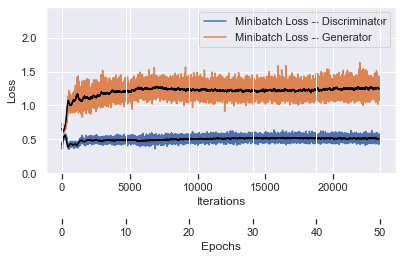

In [21]:
def plot_multiple_training_losses(losses_list, num_epochs,
                                  averaging_iterations=100, custom_labels_list=None):

    for i, _ in enumerate(losses_list):
        if not len(losses_list[i]) == len(losses_list[0]):
            raise ValueError('All loss tensors need to have the same number of elements.')

    if custom_labels_list is None:
        custom_labels_list = [str(i) for i,_ in enumerate(custom_labels_list)]

    iter_per_epoch = len(losses_list[0]) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)

    for i, minibatch_loss_tensor in enumerate(losses_list):
        ax1.plot(range(len(minibatch_loss_tensor)),
                 (minibatch_loss_tensor),
                  label=f'Minibatch Loss{custom_labels_list[i]}')
        ax1.set_xlabel('Iterations')
        ax1.set_ylabel('Loss')

        ax1.plot(np.convolve(minibatch_loss_tensor,
                             np.ones(averaging_iterations,)/averaging_iterations,
                             mode='valid'),
                 color='black')

    if len(losses_list[0]) < 1000:
        num_losses = len(losses_list[0]) // 2
    else:
        num_losses = 1000
    maxes = [np.max(losses_list[i][num_losses:]) for i, _ in enumerate(losses_list)]
    ax1.set_ylim([0, np.max(maxes)*1.5])
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()



plot_multiple_training_losses(
    losses_list=(log_dict['train_discriminator_loss_per_batch'],
                 log_dict['train_generator_loss_per_batch']),
    num_epochs=NUM_EPOCHS, 
    custom_labels_list=(' -- Discriminator', ' -- Generator')
)

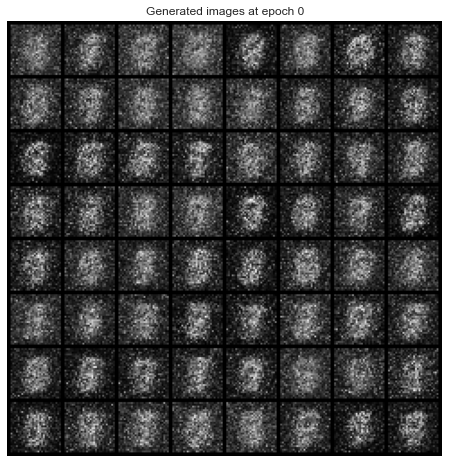

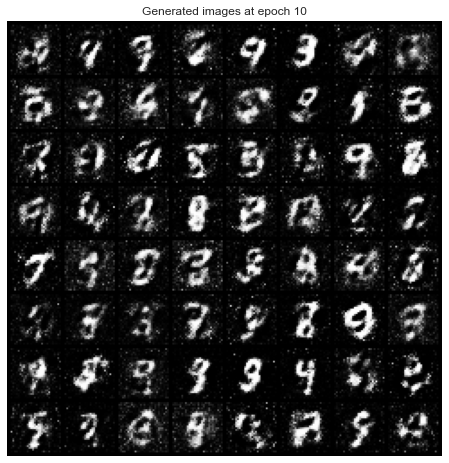

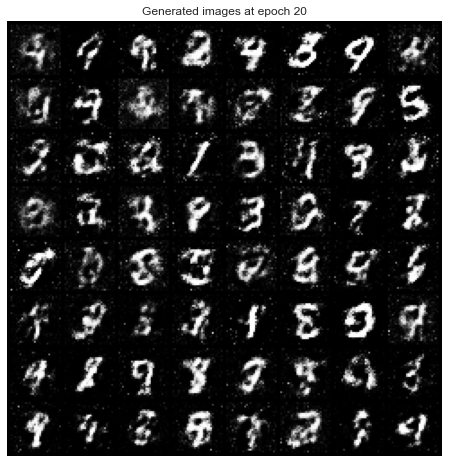

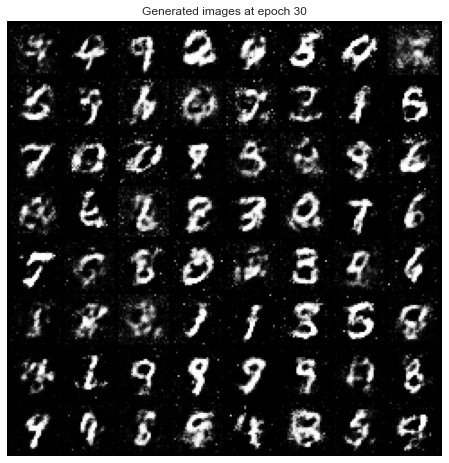

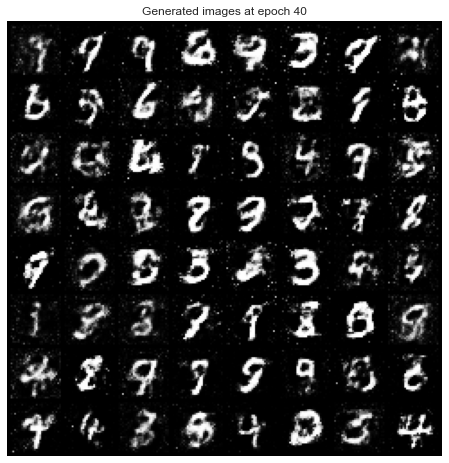

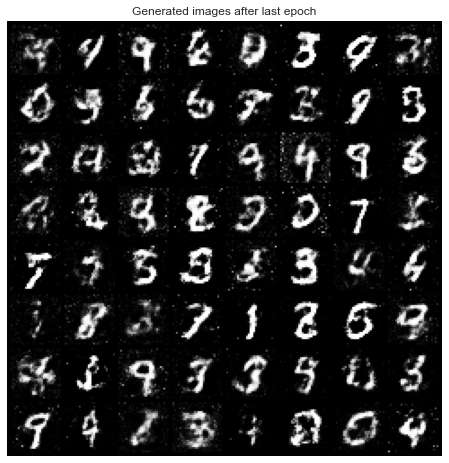

In [22]:
##########################
### VISUALIZATION
##########################

for i in range(0, NUM_EPOCHS, 10):
    
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(f'Generated images at epoch {i}')
    plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][i], (1, 2, 0)))
    plt.show()
    
    
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images after last epoch')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()

## GANs problems
---

* **Loss oscilate**: oscilated loss is not stable, due to the adverserial set-up and (almost) never converge.
<center><img src="img/gan_osil.png" width="500"/></center>


* **Mode Collapse**: the *Generator* collapses, which produces limited varieties of samples.
    - 2D eight-Gaussians dataset
<center><img src="img/collaps.PNG" width="500"/></center>

[source](https://arxiv.org/pdf/1611.02163.pdf)
    
* **Vanisihng/Diminishing Gradient**: the discriminator gets *too good* such that the generator gradient vanishes and learns nothing.
    * Proof: consider the second term in the objective function which is relavent only for the generator.
        * Recall that the output of binary classification is the output of the *sigmoid* function, $\sigma$.
        * $\nabla_{\theta_G}V(D,G) = \nabla_{\theta_G}\mathbb{E}_{z\sim q(z)} \left[\log(1 - D\left(G(z)\right)) \right]$
        * $\nabla_a \log\left(1 - \sigma(a)\right) = \frac{-\nabla_a \sigma(a)}{1 - \sigma(a)} = \frac{-\sigma(a)\left(1 - \sigma(a)\right)}{1 - \sigma(a)} = -\sigma(a) = -D\left(G(z)\right)$
        * So if $D$ is confident (that the sample is fake), the gradient goes to 0, i.e. $D\left(G(z)\right) \to 0$
    * Possible remedy: replace the problematic term with $$ \mathbb{E}_{z\sim q(z)} \left[\log(1 - D\left(G(z)\right)) \right] \rightarrow -\mathbb{E}_{z\sim q(z)} \left[\log D\left(G(z)\right) \right] $$
    
* **GANs are highly sensitive to hyper-parameters!**
    * Even the slightest change in hyper-parameters may lead to any of the above, e.g. even changing the learning rate from 0.0002 to 0.0001 may lead to instability. 
    

## Deep Conv GAN (DCGAN)

As we've already learned with DNNs, the next idea after MLP, at least with images is always convolutions.

The idea is as follow:
- Replace fully-connected (FC) hidden layers with convolutions.
- Use fractional stride/transpose convolutions (in G)
- Use *Batch Normalization* after each layer.
- Hidden layers are activated with ReLUs.
- Output layer is activated with Tanh (normalized between $[-1, 1]$).

<center><img src="img/DCGAN.png" width="1200"/></center>


## Next step GANs

* **WGAN** - [Wasserstein GANs](https://arxiv.org/abs/1701.07875) use the Wasserstein ([Earth Movers](https://en.wikipedia.org/wiki/Earth_mover%27s_distance)) distance as the loss function.<br> Think of it as so far, we measure the Jensen-Shannon divergence, a “vertical“ distance of distribution. this GAN make use of a "horizontal" distance to ensure higher rate of convergence. That makes the training more stable.

<center><img src="img/wdistance.PNG" width="1200"/></center>
<center><img src="img/Earth-Movers-Distance.png" width="800"/></center>
image from "Efficient EMD-based similarity search in multimedia databases via flexible dimensionality reduction"

* **WGAN-GP** - improves upon the original WGAN by using *Gradient Penalty* in the loss function (instead of *value clipping*)
    
* **EBGAN** - [Energy-Based GANs](https://arxiv.org/abs/1609.03126) use *autoencoders* in their architecture (with the autoencoder loss).<br>
Yann LeCun (NYU, VP@META) is the current lead of energy based models in the world, we might talk about it in the last tutorial. 
    
* **BEGAN** - Boundary Equilibrium GANs combines *autoencoders* and Wassertein distance to balance the generator and discriminator during training.
    * <a href="https://arxiv.org/abs/1703.10717">BEGAN Paper</a>, <a href="https://github.com/anantzoid/BEGAN-pytorch">PyTorch Code</a>
* **Mimicry** - a lightweight PyTorch library aimed towards the reproducibility of GAN research - <a href="https://github.com/kwotsin/mimicry">GitHub</a>

## Conditional GAN
---

* As you probably have noticed, we don't too much control over the latent space, e.g., with vanilla-GAN trained on MNIST we can't control what digit we are generating.
* **Conditional-GANs** - a simple modification to the original GAN framework that *conditions* the model on additional information for better multi-modal learning.

<center><img src="img/cgan.png" width="800"/></center>


1. **Conditional GAN**<br>
Conditional GAN (CGAN), the auxiliary data (class label) – is fed directly into both G and D. This has two benefits.
- It allows the user to control the feature being generated.
- A higher quality of generated sample can be achieved, since the distribution that the model learns to replicate is much more consistent when it represents the same digit.  The output of the Discriminator is still a probability, but now it is $P(X|c)$

2. **SGAN**<br>
Semi-Supervised GAN (SGAN), rather than feeding class labels into D, it is instead trained to assign class labels for itself.
- The output of D is no longer a probability, but a `softmax`, describing the output class. If the assigned class is between 0-9.
- Alternatively, the 11th potential class output is fake.
- This results with G which produces more convincing samples than in the original GAN model. This is intuitive, since D has an extra distinguishing factor than usual – it is arguably simpler to justify that ‘this image is probably real, since it looks like an eight’, than ‘this image is probably real’.

3. **InfoGAN**<br>
Information Theoretic GAN (InfoGAN), is another approach to conditional GANs. In this method, the specific distributions of the important features of latent codes, c, are not known. Instead, a prior is put on c and then updated, using observations, to come up with the conditional distribution $p(c|X)$.The form of the initial distribution of c allows some control over the modes which are distributed over.
- Think of it like that: instead of a discreat label added to the noise vector $Z$, we add a latent vector $C$ that represent better features of the sample (like shape, orientation)
- To ensure that the latent code is not ignored an extra term is added to the objective – the mutual information between c and the generated distribution, $G(z,c)$. D outputs both the probability that the sample is real or fake, plus the learned parameters, c. As well as providing a much more complex feature representation, this model allows us to fine tune many different aspects of the generated samples
<center><img src="img/infogan.png" width="400"/></center>



4. **AC-GAN**<br>
Also by Odena (where the image is taken from) with Auxiliary-Classifier GAN (AC-GAN).

- Similarly to SGAN, D is trained to assign class labels to samples, however it is combined this time with the feature of CGANs, whereby the latent code, c, is also fed into G. That is, not only does G receive the noise sample, but a one-hot vector describing to which class the output should belong. restricting the number of classes that G is tasked to imitate results in better sample quality. This makes sense, as it is asked to learn fewer distributions. They also show how this model scales well to high-res distributions (for 2016), such as ImageNet.

* As we learn how to transform a latent vector, $z$, to images, we actullay learn a latent continuous space.
* This continuous spcae allows us to perform interpolation and arithmetics.
* As this space is continuous, unlike the original data (images), it was found that some operations (like summing) perform really well when done on the latent space.
* As you can see below, those operations were demonstrated in the paper <a href="https://arxiv.org/abs/1511.06434">Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks, Alec Radford, Luke Metz, Soumith Chintala, ICLR 2016</a>

<center><img src="img/larit.PNG" width="700"/></center>
(from Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks.)

one aplicable example could be hair style transfer (the rest you know from your phone aplications..)
<center><img src="img/hairstyle.jpeg" width="800"/></center>



you can use [artbreeder](https://www.artbreeder.com/) to play with that some

### [Image-to-Image Translation with Conditional Adversarial Nets](https://phillipi.github.io/pix2pix/)
Pix2pix uses a conditional generative adversarial network (cGAN) to learn a function to map from an input image to an output image.
The Generator transforms the input image to get the output image.
The Discriminator measures the similarity of the input image to an unknown image (either a target image from the dataset or an output image from the generator) and tries to guess if it real or fake
some explenation [here](https://neurohive.io/en/popular-networks/pix2pix-image-to-image-translation/)

## StyleGan

As you can see, Researchers had trouble generating high-quality large images (e.g. 1024×1024) until 2018, when **NVIDIA** came up with Progressive Growing of GANs for Improved Quality, Stability, and Variation (**PROGAN**)

The key idea is to downsample images and train first (both G and D) by very small images, and increase size with time.<br>

<center><img src="img/progan.PNG" width="800"/></center>



as it turns out, not only that small images train faster, but the features of small images are good for big images. and the hole optimization process is faster and achive better results. 

<center><img src="img/progang.gif" width="800"/></center>

this model still lake of control over specific features of the generated image.
The features are entangled and therefore attempting to tweak the input, even a bit, usually affects multiple features at the same time...

In 2018 came a paper called **Style GAN** that took a step forward:

Nvidia distinguished between features that the generator can learn to produce in diffrent levels, and catalog them into 3:

- Coarse - resolution of up to 82 - affects pose, general hair style, face shape, etc
- Middle - resolution of 162 to 322 - affects finer facial features, hair style, eyes open/closed, etc.
- Fine - resolution of 642 to 10242 - affects color scheme (eye, hair and skin) and micro features.

#### Mapping Network

The goal is to encode input vector $Z$ into an intermediate vector, that each elements control different visual features. that's called **features entanglement**<br>
So far, the latent space was random in order and this is a non-trivial process, you can think how hard it is to encapsule features, when the data never balanced by all features (there are more people with black hair in the world, and this feature is easier to learn then pink hair).<br>
This process can be learned with another neural network.
<center><img src="img/mapping_net.png" width="800"/></center>


#### Style Modules (AdaIN)
The AdaIN (Adaptive Instance Normalization) module 

transfers the encoded information ⱳ, created by the Mapping Network, into the generated image. The module is added to each resolution level of the Synthesis Network and defines the visual expression of the features in that level:
* Each channel of the convolution layer output is first normalized to make sure the scaling and shifting of step 3 have the expected effect.
* The intermediate vector ⱳ is transformed using another fully-connected layer (marked as A) into a scale and bias for each channel.
* The scale and bias vectors shift each channel of the convolution output, thereby defining the importance of each filter in the convolution. This tuning translates the information from ⱳ to a visual representation.

<center><img src="img/style2.png" width="800"/></center>


each scale is also loaded with stochastic normelized (channel-wize) nosie
<center><img src="img/style2-scalednoise.png" width="700"/></center>


and the final scheme looks like that:
<center><img src="img/stylefinal.png" width="800"/></center>


The results are marvelous:

https://thispersondoesnotexist.com/

[69 stylegan based aplications](https://awesomeopensource.com/projects/stylegan)

#### Thanks

In [27]:
def train_gan_v2(num_epochs, model, optimizer_gen, optimizer_discr, 
                 latent_dim, device, train_loader, loss='regular',
                 logging_interval=100, 
                 save_model=None):
    
    log_dict = {'train_generator_loss_per_batch': [],
                'train_discriminator_loss_per_batch': [],
                'train_discriminator_real_acc_per_batch': [],
                'train_discriminator_fake_acc_per_batch': [],
                'images_from_noise_per_epoch': []}

    if loss == 'regular':
        loss_fn = F.binary_cross_entropy_with_logits
    elif loss == 'wasserstein':
        def loss_fn(y_pred, y_true):
            return -torch.mean(y_pred * y_true)
    else:
        raise ValueError('This loss is not supported.')

    # Batch of latent (noise) vectors for
    # evaluating / visualizing the training progress
    # of the generator
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device) # format NCHW

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            batch_size = features.size(0)

            # real images
            real_images = features.to(device)
            real_labels = torch.ones(batch_size, device=device) # real label = 1

            # generated (fake) images
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)  # format NCHW
            fake_images = model.generator_forward(noise)
            
            if loss == 'regular':
                fake_labels = torch.zeros(batch_size, device=device) # fake label = 0
            elif loss == 'wasserstein':
                fake_labels = -real_labels # fake label = -1    
            flipped_fake_labels = real_labels # here, fake label = 1

            # --------------------------
            # Train Discriminator
            # --------------------------

            optimizer_discr.zero_grad()

            # get discriminator loss on real images
            discr_pred_real = model.discriminator_forward(real_images).view(-1) # Nx1 -> N
            real_loss = loss_fn(discr_pred_real, real_labels)
            # real_loss.backward()

            # get discriminator loss on fake images
            discr_pred_fake = model.discriminator_forward(fake_images.detach()).view(-1)
            fake_loss = loss_fn(discr_pred_fake, fake_labels)
            # fake_loss.backward()

            # combined loss
            discr_loss = 0.5*(real_loss + fake_loss)
            discr_loss.backward()

            optimizer_discr.step()
            
            if loss == 'wasserstein':
                for p in model.discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)

            # --------------------------
            # Train Generator
            # --------------------------

            optimizer_gen.zero_grad()

            # get discriminator loss on fake images with flipped labels
            discr_pred_fake = model.discriminator_forward(fake_images).view(-1)
            gener_loss = loss_fn(discr_pred_fake, flipped_fake_labels)
            gener_loss.backward()

            optimizer_gen.step()

            # --------------------------
            # Logging
            # --------------------------   
            log_dict['train_generator_loss_per_batch'].append(gener_loss.item())
            log_dict['train_discriminator_loss_per_batch'].append(discr_loss.item())
            
            predicted_labels_real = torch.where(discr_pred_real.detach() > 0., torch.tensor(1.), torch.tensor(0.))
            predicted_labels_fake = torch.where(discr_pred_fake.detach() > 0., torch.tensor(1.), torch.tensor(0.))
            acc_real = (predicted_labels_real == real_labels).float().mean()*100.
            acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
            log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
            log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())         
            
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                       % (epoch+1, num_epochs, batch_idx, 
                          len(train_loader), gener_loss.item(), discr_loss.item()))

        ### Save images for evaluation
        with torch.no_grad():
            fake_images = model.generator_forward(fixed_noise).detach().cpu()
            log_dict['images_from_noise_per_epoch'].append(
                torchvision.utils.make_grid(fake_images, padding=2, normalize=True))


        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    
    return log_dict


In [ ]:
l= train_gan_v2(NUM_EPOCHS, model, optim_gen, optim_discr, 
                 100, device, train_loader, 'wasserstein',100, 
                 'gan_mnist_02.pt')

Epoch: 001/050 | Batch 000/469 | Gen/Dis Loss: 0.0108/-0.0000
Epoch: 001/050 | Batch 100/469 | Gen/Dis Loss: 0.0102/-0.0001
Epoch: 001/050 | Batch 200/469 | Gen/Dis Loss: 0.0096/-0.0001
Epoch: 001/050 | Batch 300/469 | Gen/Dis Loss: 0.0061/-0.0012
Epoch: 001/050 | Batch 400/469 | Gen/Dis Loss: 0.0031/-0.0004
Time elapsed: 0.24 min
Epoch: 002/050 | Batch 000/469 | Gen/Dis Loss: -0.0007/-0.0008
Epoch: 002/050 | Batch 100/469 | Gen/Dis Loss: -0.0116/-0.0017
Epoch: 002/050 | Batch 200/469 | Gen/Dis Loss: -0.0207/-0.0022
Epoch: 002/050 | Batch 300/469 | Gen/Dis Loss: -0.0283/0.0001
Epoch: 002/050 | Batch 400/469 | Gen/Dis Loss: -0.0387/-0.0045
Time elapsed: 0.47 min
Epoch: 003/050 | Batch 000/469 | Gen/Dis Loss: -0.0414/-0.0025
Epoch: 003/050 | Batch 100/469 | Gen/Dis Loss: -0.0572/-0.0045
Epoch: 003/050 | Batch 200/469 | Gen/Dis Loss: -0.0627/-0.0040
Epoch: 003/050 | Batch 300/469 | Gen/Dis Loss: -0.0711/0.0015
Epoch: 003/050 | Batch 400/469 | Gen/Dis Loss: -0.0792/-0.0017
Time elapsed: 0.

**Credits**

This tutorial was written by [Moshe Kimhi](https://www.linkedin.com/in/moshekimhi/)<br>
To re-use, please provide attribution and link to the original.


some code snips from:<br>
[kernel-density-estimation](https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html)

images sources:
https://developers.google.com/machine-learning/gan/generator<br>
https://towardsdatascience.com/comprehensive-introduction-to-turing-learning-and-gans-part-2-fd8e4a70775
https://towardsdatascience.com/explained-a-style-based-generator-architecture-for-gans-generating-and-tuning-realistic-6cb2be0f431